In [1]:
import torch
import torch.nn as nn

torch.__version__

'2.2.1+cu118'

# Device agnostic code

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
device

device(type='cuda')

# Getting the data

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# if the image folder does not exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exits.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        print("Downloading pizza, steak, sushi data...")
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        f.write(request.content)

    # Unzip data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping data")
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exits.


# Data preparation

In [4]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak


In [5]:
# Setup train and testing paths

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# Visualizing and image

data/pizza_steak_sushi/train/steak/1413972.jpg
Random image path: data/pizza_steak_sushi/train/steak/1413972.jpg
Image class: steak
Image height: 512
Image width: 512


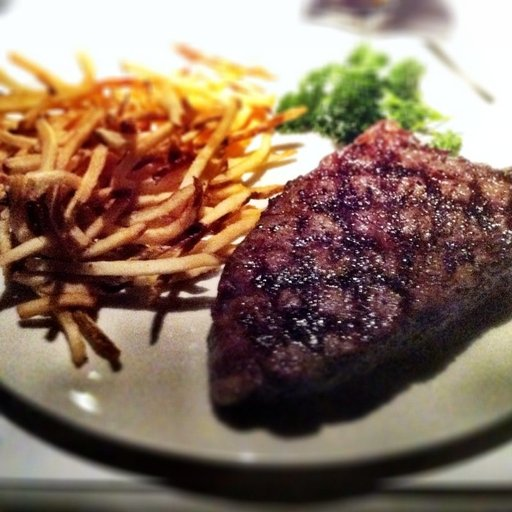

In [6]:
import random
from PIL import Image

# random.seed(42)

# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# Get image class
image_class = random_image_path.parent.stem

# Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

Text(0.5, 1.0, 'Image class: steak | Image shape (height, width, color_channels): (512, 512, 3)')

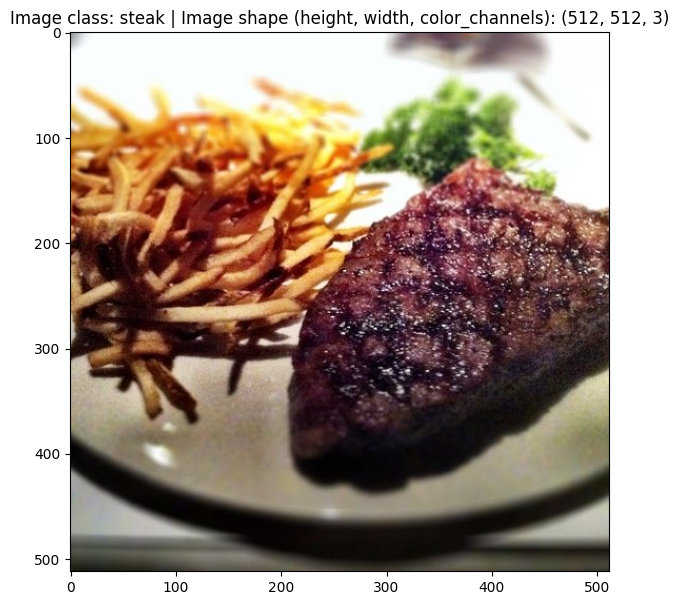

In [7]:
import matplotlib.pyplot as plt
import numpy as np

img_as_array = np.asarray(img)

plt.figure(figsize=(7, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape (height, width, color_channels): {img_as_array.shape}")

# Transforming data

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Transforming data with torchvision

In [9]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Convert to tensor
    transforms.ToTensor()
])

In [10]:
data_transform(img).shape

torch.Size([3, 64, 64])

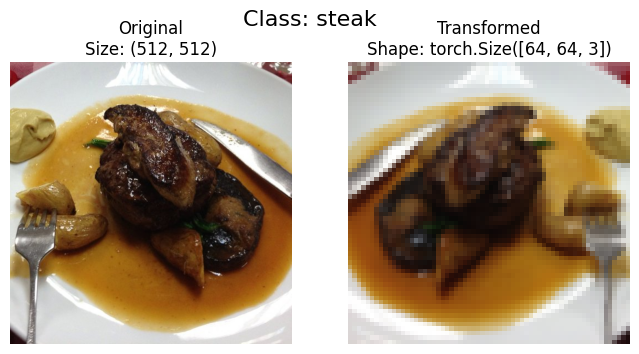

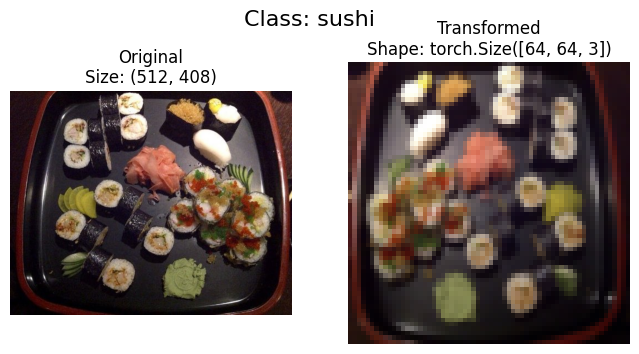

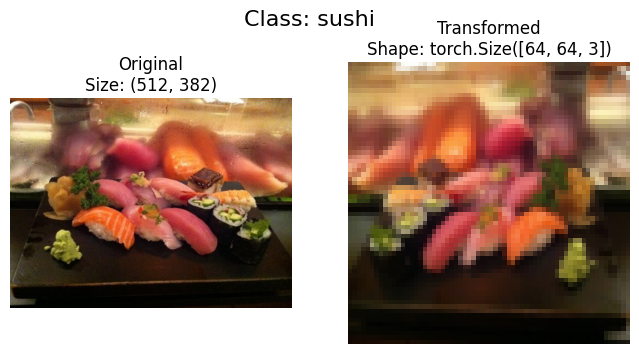

In [11]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    if seed:
        random.seed(seed)
    
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)
            
            # Transform and plot target image
            # (C, H, W) -> (H, W, C)
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis(False)
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, transform=data_transform,
                        n=3, seed=42)

# Loading image data using image folder

In [12]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [13]:
class_names = train_data.classes
class_dict = train_data.class_to_idx
class_names, class_dict

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [14]:
len(train_data), len(test_data)

(225, 75)

In [15]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

### Index on the train_data dataset to get a single image and label

In [16]:
img, label = train_data[0]
img.shape, label, class_names[label]

(torch.Size([3, 64, 64]), 0, 'pizza')

In [17]:
print(f"Image tensor: \n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor: 
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

### Turn loaded images into `DataLoader`

In [18]:
# Turn train and test datasets into DataLoader
from torch.utils.data import DataLoader

BATCH_SIZE=16
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=0,
                             shuffle=False)

len(train_dataloader), len(test_dataloader)

(15, 5)

In [19]:
next(iter(train_dataloader))[0].shape

torch.Size([16, 3, 64, 64])

In [20]:
img, label = next(iter(train_dataloader))
img.shape, label.size()

(torch.Size([16, 3, 64, 64]), torch.Size([16]))

## Loading Image Data with Custom `Dataset`

In [21]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

### Creating helper function to get class names

In [22]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [23]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted([entry.name for entry in os.scandir(target_directory) if entry.is_dir()])

    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure")

    class_to_idx = {classname: i for i, classname in enumerate(classes)}

    return classes, class_to_idx

In [24]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Creating custom dataset by subclassing `torch.utils.data.Dataset`

In [25]:
from torch.utils.data import Dataset

# 1. Subclass Dataset

class ImageFolderCustom(Dataset):
    def __init__(self, targ_dir: str, transforms=None):
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        
        # Setup transforms
        self.transforms = transforms
        
        # Create classes and class_to_idx
        self.classes, self.class_to_idx = find_classes(targ_dir)

    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)
    
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        # expects path: data_folder/class_name/image.jpg
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transforms:
            return self.transforms(img), class_idx
        else:
            img, class_idx

In [26]:
# Create a transform
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [27]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transforms=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transforms=test_transforms)

In [28]:
train_data_custom, train_data

(<__main__.ImageFolderCustom at 0x7f2baef48ca0>,
 Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [29]:
len(train_data_custom), len(train_data)

(225, 225)

In [30]:
len(test_data_custom), len(test_data)

(75, 75)

In [31]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [32]:
# Create a function to show random images

def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int=10,
                          display_shape: bool = True,
                          seed: int = 42):
    random.seed(seed)

    # get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    
    # Setup plot
    plt.figure(figsize=(16, 8))

    # Loop through random indexes and plot 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_iamge, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # adjust tensor dimenstions for plotting
        targ_iamge_adjust = targ_iamge.permute(1, 2, 0) #[C, H, W]->[H, W, C]

        # plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_iamge_adjust)
        plt.axis(False)

        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_iamge_adjust.shape}"
        
        plt.title(title)

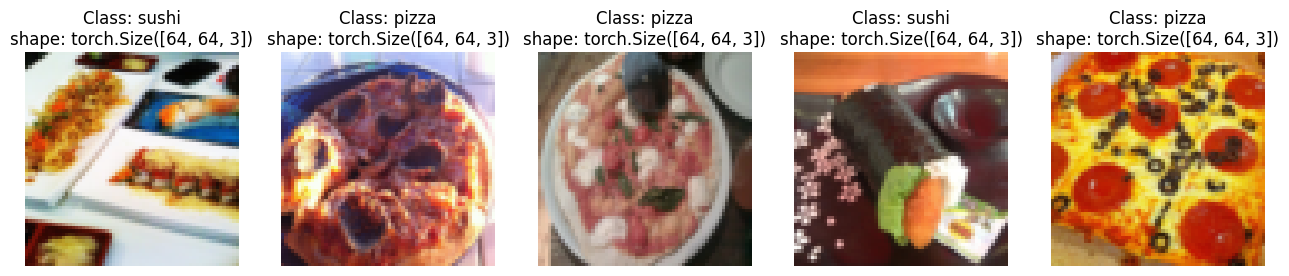

In [33]:
# display random images from ImageFolder created dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names)

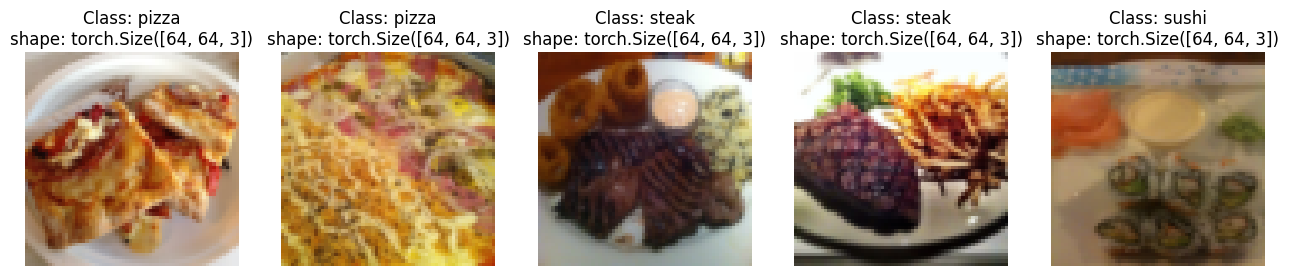

In [38]:
# display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=5, classes=class_names,
                      seed=None)

### Turn custom loaded images to DataLoader

In [39]:
from torch.utils.data import DataLoader
BATCH_SIZE = 16

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=os.cpu_count(),
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=0,
                                    shuffle=False)

In [40]:
img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([16, 3, 64, 64]), torch.Size([16]))

# Data Augmentation

In [41]:
# Trivial augment
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [42]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/sushi/1680893.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2741434.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1600999.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/988559.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1987407.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/3196729.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1172255.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/684266.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2715127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/207578.jpg')]

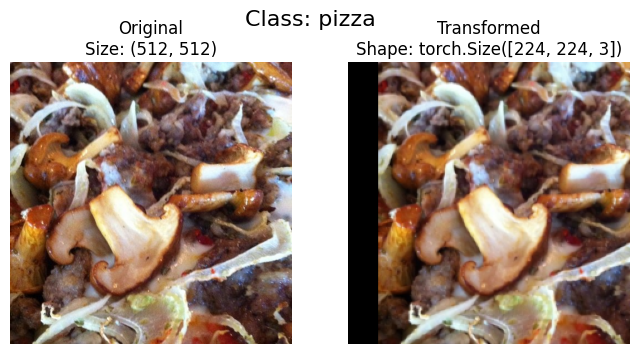

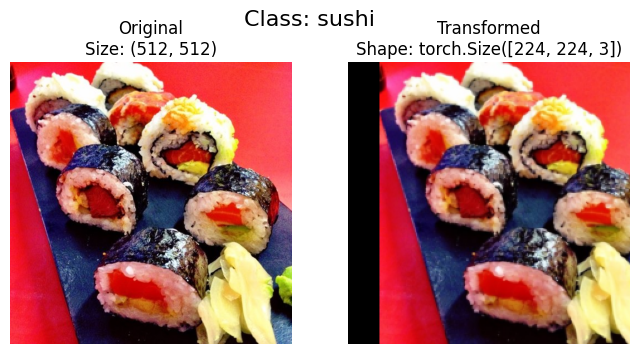

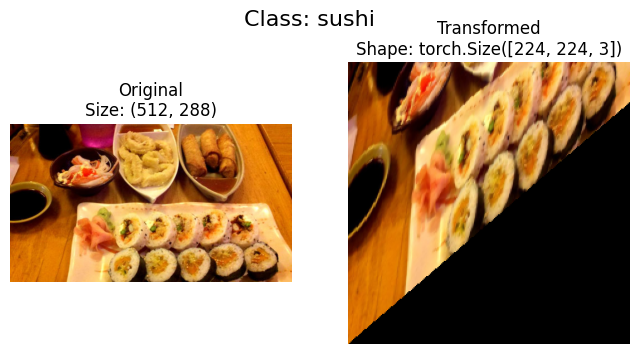

In [46]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms, n=3, seed=None
)